In [1]:
import copy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import scipy
from typing import List, Tuple

from cartpole_dynamics import CartpoleDynamics
from dynamics import *
from quadratic_program import QuadraticProgram
from solvers import InfeasibleStartNewton, FeasibleStartNewton
from trajectory_optimizer import TrajectoryOptimizer

In [2]:
np.set_printoptions(threshold=np.inf)
scipy.special.seterr(all='ignore')

import warnings
warnings.filterwarnings("ignore")

## References

https://cse.lab.imtlucca.it/~bemporad/publications/papers/ijc_rtiltv.pdf

https://web.stanford.edu/~boyd/papers/pdf/fast_mpc.pdf

https://www.imtek.de/professuren/systemtheorie/events/dateien/directshootingmethods

https://www.matthewpeterkelly.com/tutorials/trajectoryOptimization/cartPoleCollocation.svg#frame1114

In [3]:
def pendulum_position(z: np.ndarray, l_pend: float):
   '''
   Returns the position of the mass at the end of a pendulum attached to a cart given some current system state.
   - z = Cartpole system state: [cart position, pendulum angle, cart speed, pendulum angular speed]
   - l_pend = Length of a pendulum
   '''
   return np.array([z[0] + l_pend * np.sin(z[1]), -l_pend * np.cos(z[1])])

In [4]:
def plot_pendulum_time_sequence(states: List[np.ndarray], l_pend: float, keyframe_stride: int=4, title_prefix: str | None=None, filename: str | None=None):
   '''
   Plots the cart position, pendulum arm, and pendulum mass position for a sequence of 4d
   states indicating the system's [cart_pos, pendulum_angle, cart_speed, pendulum_angular_speed].

   Add shapes to matplotlib plot:
   https://www.scaler.com/topics/matplotlib/plot-shape-matplotlib/

   - states = List of cartpole states
   - l_pend = Length of the pendulum
   - keyframe_stride = Number of frames to skip plotting the whole cartpole system
   - filename = Name of the file to save the plot to
   '''

   positions = [pendulum_position(z, l_pend) for z in states]

   title_prefix = "" if title_prefix is None else title_prefix

   keyframe_states = [s for i, s in enumerate(states) if (i % keyframe_stride) == 0]

   keyframe_colors = cm.rainbow(np.linspace(0, 1, int(len(states) / keyframe_stride) + 1))
   colors = cm.rainbow(np.linspace(0, 1, len(states)))
   fig = plt.figure()
   ax = fig.add_subplot()
   # ax.set_ylim([-1.25 * l_pend, 1.25 * l_pend])
   for i, ks in enumerate(keyframe_states):
      cart = plt.Rectangle((ks[0] - 0.125/2, 0.0), 0.125, 0.125/2, fc=keyframe_colors[i])
      pend_pos = pendulum_position(ks, l_pend)
      plt.plot([ks[0], pend_pos[0]], [0.0, pend_pos[1]], color=keyframe_colors[i])
      plt.gca().add_patch(cart)
   plt.scatter([p[0] for p in positions], [p[1] for p in positions], color=colors, s=0.25)
   
   # plt.axis('equal')
   plt.ylim(-1.25 * l_pend, 1.25 * l_pend)
   plt.gca().set_aspect('equal')
   if filename is not None:
      plt.savefig(filename, dpi=8000.0, bbox_inches='tight')

   fig = plt.figure()
   plt.title(title_prefix + " pendulum angle")
   plt.plot([z[1] for z in states])
   fig = plt.figure()
   plt.title(title_prefix + " position")
   plt.plot([z[0] for z in states])
   fig = plt.figure()
   plt.title(title_prefix + " cart speed")
   plt.plot([z[2] for z in states])
   fig = plt.figure()
   plt.title(title_prefix + " pendulum angular speed")
   plt.plot([z[3] for z in states])

   plt.show()

In [5]:
def cartpole_demo(z_init: np.ndarray, u_init: float, t_max: float, u_max: float=1.0):
   zs = []
   zs.append(copy.copy(z_init))
   dt = 0.01

   cp_dynamics = CartpoleDynamics(1.0, 1.0, 1.0, -u_max, u_max)

   for i in range(int(t_max / dt)):
      zs.append(cp_dynamics.step(zs[-1], u_init, dt, dt * i))

   plot_pendulum_time_sequence(zs, 1.0)

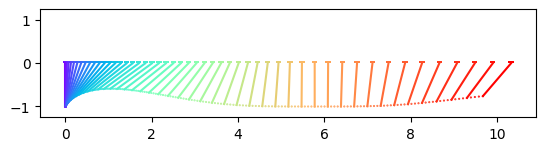

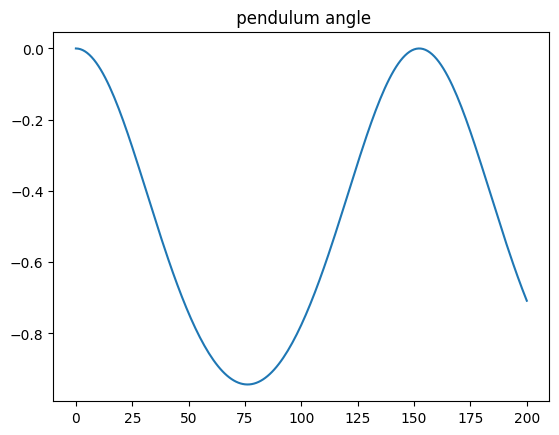

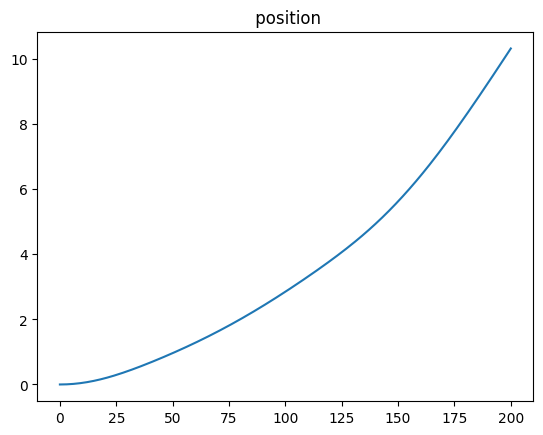

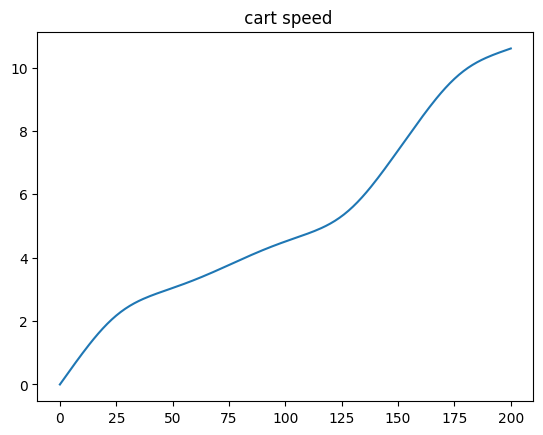

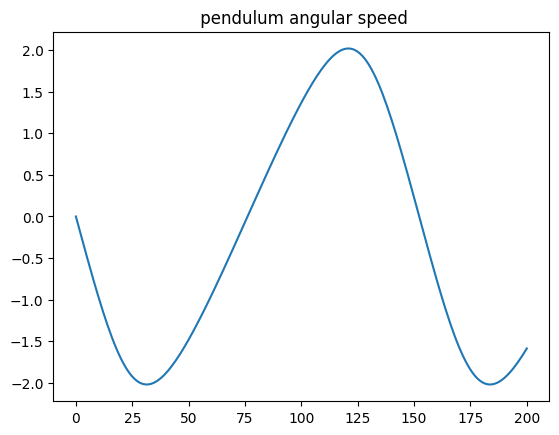

In [6]:
cartpole_demo(np.array([0.0, 0.0, 0.0, 0.0]), 10.0, 2, u_max=10.0)

The dynamics of a system are governed by

$\dot{\mathbf{z}} = f(t, \mathbf{z}, u)$

where $t$ is time, $\mathbf{z}$ is the system's state, and $u$ is a control input applied to the system. Then the system's linearized dynamics are given by

$\dot{\mathbf{z}} = f(t, \mathbf{z}, u) \approx f(t_0, \mathbf{z}_0, u_0) + \nabla_{\mathbf{z}}f(t_0, \mathbf{z}_0, u_0)^T (\mathbf{z} - \mathbf{z}_0) + \nabla_uf(t_0, \mathbf{z}_0, u_0)^T(u - u_0)$

or, using the terms from the following function,

$\dot{\mathbf{z}} = \mathbf{r}(t_0, \mathbf{z}_0, u_0) + A \mathbf{z} + \mathbf{b}u$

for some initial time, state, and control input.

\begin{equation}
x(t) = e^{A(t - t_0)}x(t_0) + e^{At}\int_{t_0}^{t}e^{A\tau} \left( b u(\tau) + f \right) d\tau
\end{equation}

When $u(\tau) = u_0$ for $t_0 \leq t \leq t$ the convolution integral becomes

\begin{equation}
x(t) = e^{A(t - t_0)}x(t_0) + \left( e^{A(t - t_0)} - \mathbb{I} \right)A^{-1}(b u_0 + f)
\end{equation}

$A \in \mathbb{R}^{n \times n}$ is the Jacobian of the nonlinear system dynamics with respect to $x \in \mathbb{R}^n$

$b \in \mathbb{R}^n$ is the Jacobian of the nonlinear system dynamics with respect to $u \in \mathbb{R}$

$f \in \mathbb{R}^n$ is the constant term that comes from linearizing the system dynamics about a non-fixed point

The state transition matrix is defined as

\begin{equation}
\Phi(t) = e^{At}
\end{equation}

and transitioning from one state to the next state is done via

\begin{equation}
\mathbf{x}_{t+\delta t} = \Phi(t + \delta t, t) \mathbf{x}_{t}
\end{equation}

In [7]:
def plot_control_input(us: List[np.ndarray], dt: float, title_prefix: str | None=None, filename: str = None):
   '''
   Plots a sequence of control inputs

   - us = A sequence of control inputs
   - dt = Time duration over which the LTI system is simulated
   - filename = Name of the file the plot should be saved to
   '''

   title_prefix = "" if title_prefix is None else title_prefix

   t_vals = [dt * n for n in range(len(us))]
   plt.title(title_prefix + " control input")
   plt.plot(t_vals, [u for u in us])
   # plt.plot([u for u in us])
   plt.xlabel("Time (s)")
   plt.ylabel("Control effort")
   plt.show()
   if filename is not None:
      plt.savefig(filename, dpi=800.0, bbox_inches='tight')


## Trajectory Optimization

In [36]:
def cartpole_trajectory_optimizer_linear(
   N: int,
   T: float,
   dynamics: CartpoleDynamics,
   z_0: np.ndarray,
   z_f: np.ndarray | None=None,
   z_f_penalty: float | None=None,
   ref_trajectory: List[np.ndarray] | None=None,
   ref_trajectory_weight: float | None=None,
   relinearization_sequence: List[np.ndarray] | None=None,
   warm_zs: List[np.ndarray] | None=None,
   warm_us: List[float] | None=None,
) -> Tuple[List[np.ndarray], List[np.ndarray], bool]:
   effort_weights = np.ones(N * dynamics.control_size)

   state_weights = None
   if ref_trajectory is not None:
      if ref_trajectory_weight is None:
         state_weights = 100.0 * np.tile([1.0, 1.0, 0.0, 0.0], N)
      else:
         state_weights = ref_trajectory_weight * np.tile([1.0, 1.0, 0.0, 0.0], N)

   to = TrajectoryOptimizer(
      effort_weights,
      N,
      T,
      z_0,
      dynamics,
      final_state=z_f,
      reference_trajectory=ref_trajectory,
      state_weights=state_weights,
      final_state_penalty=z_f_penalty,
      relinearization_sequence=relinearization_sequence,
   )

   # zs and us for warm-starting infeasible newton
   if warm_zs is None:
      delta_tau = (1.0 / N)
      # if z_f is not None and z_f_penalty is None:
      #    warm_zs = [(1 - i * delta_tau) * z_0 + i * delta_tau * z_f for i in range(N)]
      # else:
      #    warm_zs = [(1 - i * delta_tau) * z_0 + i * delta_tau * np.zeros(dynamics.state_size) for i in range(N)]
      warm_zs = [(1 - i * delta_tau) * z_0 + i * delta_tau * z_f for i in range(N)]

   if warm_us is None:
      warm_us = [0.000,] * (N)

   print("z_0: ", warm_zs[0])
   print("z_f: ", warm_zs[-1])

   x_init = np.hstack(warm_us + warm_zs)
   v_init = None
   if z_f is not None and z_f_penalty is None:
      v_init = np.ones(dynamics.state_size * (N + 1)) * 0.01
   else:
      v_init = np.ones(dynamics.state_size * N) * 0.01

   x_out, v_out, feasible = to.gogogo(x_init, v_init, max_num_newton_iters=400, max_num_ipm_iters=4)

   dense_zs = to.get_states(x_out)
   dense_zs.insert(0, z_0)
   dense_us = to.get_inputs(x_out)

   return dense_zs, dense_us, feasible

In [37]:
def cartpole_trajectory_optimizer_nonlinear(
   N: int,
   T: float,
   dynamics: CartpoleDynamics,
   z_0: np.ndarray,
   z_f: np.ndarray | None=None,
   z_f_penalty: float | None=None,
) -> Tuple[List[List[Tuple[np.ndarray, np.ndarray]]], List[List[Tuple[np.ndarray, np.ndarray]]]]:
   '''
   Returns the optimized trajectories and nonlinear trajectories for each
   relinearization of the dynamics from a previously optimized trajectory.
   [optimized_trajectories, nonlinear_trajectories]
   '''
   optimized_trajectories: List[List[Tuple[np.ndarray, np.ndarray]]] = []
   nonlinear_trajectories: List[List[Tuple[np.ndarray, np.ndarray]]] = []

   dense_zs, dense_us, feasible = cartpole_trajectory_optimizer_linear(N, T, dynamics, z_0, z_f=z_f, z_f_penalty=100000.0)
   trajectory = [state_control for state_control in zip(dense_zs, dense_us)]
   optimized_trajectories.append(trajectory)

   if not feasible:
      print("not feasible")
      return

   print("last control input:", dense_us[-1])

   num_relinearizations = 10
   for step in range(num_relinearizations):
      print("============ step", step, "============")
      print("applying control inputs to nonliner dynamics")

      nonlinear_states = [z_0]
      dt = T / N
      num_substeps = 100
      temp_state = nonlinear_states[-1]
      for control_input in dense_us:
         for i in range(num_substeps):
            # print("temp state:", temp_state)
            temp_state = dynamics.step(
               temp_state, control_input, dt / num_substeps, 0.0
            )

         nonlinear_states.append(temp_state)

      nonlinear_trajectory = [state_control for state_control in zip(nonlinear_states, dense_us)]
      nonlinear_trajectories.append(nonlinear_trajectory)

      relin_seq = [state_control for state_control in zip(nonlinear_states, dense_us)]

      # # This is an attempt at a decent warm-start to cut down runtimes, but it
      # # doesn't really cut down runtimes.
      # dt = T / N
      # # linear_terms: List[Tuple[np.ndarray, np.ndarray, np.ndarray]] = []
      # warm_zs: List[np.ndarray] = []
      # for i, relin_vals in enumerate(relin_seq):
      #    state, control_input = relin_vals
      #    time = dt * i
      #    # linear_terms.append(dynamics.x_dot_linear(state, control_input, time))
      #    A, b, r = dynamics.x_dot_linear(state, control_input, time)
      #    phi, phi_integ = phi_and_phi_integ(A, dt)
      #    warm_zs.append(np.dot(phi, state) + (np.dot(phi_integ, b) * control_input) + np.dot(phi, r))

      dense_zs, dense_us, feasible = cartpole_trajectory_optimizer_linear(
         N,
         T,
         dynamics,
         z_0,
         z_f=z_f,
         z_f_penalty=z_f_penalty,
         relinearization_sequence=relin_seq,
         # warm_zs=copy.deepcopy(dense_zs)[1:],
         # warm_zs=warm_zs,
         # warm_us=copy.deepcopy(dense_us)
      )
      trajectory = [state_control for state_control in zip(dense_zs, dense_us)]
      optimized_trajectories.append(trajectory)

      if not feasible:
         print("not feasible")
         break

   return optimized_trajectories, nonlinear_trajectories


## Modifiable parameters

Some configurations might make the problem infeasible.

In [46]:
# Number of collocation points
N = 128
# Total amount of time
T = 1.0

u_min = -15.0
u_max = 15.0

m_pend = 0.3
m_cart = 0.3
l_pend = 0.5

dynamics = CartpoleDynamics(l_pend, m_pend, m_cart, u_min, u_max)

# z_0 = np.array([0.0, 0.0, 0.0, 0.0])
z_0 = np.array([0.33349211, 1.26873118, 0.08229249, 0.43907823])
# z_0 = np.array([ 0.36504831,  0.4345171,  -0.33516779,  0.56171952])
z_final = np.array([1.0, np.pi, 0.0, 0.0])

In [47]:
opt_trajs, nl_trajs = cartpole_trajectory_optimizer_nonlinear(
   N, T, dynamics, z_0, z_final, # z_f_penalty=100000.0
)

# Kowalski, Analysis

len(opt_trajs)
plt.title("L2 norms between states of sequential optimized trajectories")
for i in range(2, len(opt_trajs) - 1):
   states = [state for state, _ in opt_trajs[i]]
   states_prime = [state for state, _ in opt_trajs[i + 1]]

   deltas = [np.linalg.norm(state - state_prime) for state, state_prime in zip(states, states_prime)]

   plt.plot(deltas, label="sequence " + str(i) + " to " + str(i + 1))
plt.legend()
plt.show()

first_control_inputs = []
for i in range(len(opt_trajs)):
   first_input = opt_trajs[i][0][1]
   first_control_inputs.append(first_input)

plt.title("First control inputs over relinearizations")
plt.plot(first_control_inputs)
plt.show()

final_states = []
for i in range(len(opt_trajs)):
   final_state = opt_trajs[i][-1][0]
   final_states.append(final_state)

plt.title("Final states over relinearizations")
plt.plot(final_states)
plt.show()

plt.title("Control input sequences vs relinearization")
for i, trajectory in enumerate(opt_trajs):
   inputs = [state_control[1] for state_control in trajectory]
   plt.plot(inputs, label=str(i))
plt.legend()
plt.show()

plt.title("L2 norms between nonlinear trajectories and optimized linear trajectories")
i = 0
for opt_traj, nl_traj in zip(opt_trajs, nl_trajs):
   deltas = [np.linalg.norm(opt_state_control[0] - nl_state_control[0]) for opt_state_control, nl_state_control in zip(opt_traj, nl_traj)]
   plt.plot(deltas, label=str(i))
   i += 1
plt.legend()
plt.show()

# plot the pendulum states from the last linearization
plot_pendulum_time_sequence([state_control[0] for state_control in opt_trajs[-1]], dynamics._l_pend)

z_0:  [0.33349211 1.26873118 0.08229249 0.43907823]
z_f:  [9.94792907e-01 3.12696092e+00 6.42910078e-04 3.43029867e-03]
stupid infeasible newton termination criteria: inf
ifsnm num iters: 0 residual norm: 1488.9409140829998 line search param: 0.06461081889226679
ifsnm num iters: 1 residual norm: 1482.7255655160304 line search param: 0.0041745579179292966
ifsnm num iters: 2 residual norm: 1477.7134503646832 line search param: 0.00338139191352273
ifsnm num iters: 3 residual norm: 1472.3410077722385 line search param: 0.003757102126136367
ifsnm num iters: 4 residual norm: 1466.8129472552866 line search param: 0.003757102126136367
ifsnm num iters: 5 residual norm: 1461.3041618023988 line search param: 0.003757102126136367
ifsnm num iters: 6 residual norm: 1455.2132069181887 line search param: 0.0041745579179292966
ifsnm num iters: 7 residual norm: 1449.1422697872888 line search param: 0.0041745579179292966
ifsnm num iters: 8 residual norm: 1443.096044997644 line search param: 0.00417455791

KeyboardInterrupt: 

In [ ]:
# %prun cartpole_trajectory_optimizer_linear(N, T, dynamics, z_0, z_f=z_final)

In [22]:
%prun cartpole_trajectory_optimizer_linear(N, T, dynamics, z_0, z_f=z_final, z_f_penalty=100000.0)

z_0:  [0. 0. 0. 0.]
z_f:  [0.9921875  3.11704896 0.         0.        ]
stupid infeasible newton termination criteria: inf
ifsnm num iters: 0 residual norm: 1677.612207942916 line search param: 0.34867844010000015
ifsnm num iters: 1 residual norm: 1652.8199354718392 line search param: 0.014780882941434608
ifsnm num iters: 2 residual norm: 1628.4787026480012 line search param: 0.014780882941434608
ifsnm num iters: 3 residual norm: 1608.98742329792 line search param: 0.011972515182562033
ifsnm num iters: 4 residual norm: 1589.7844903514276 line search param: 0.011972515182562033
ifsnm num iters: 5 residual norm: 1570.7886263565558 line search param: 0.011972515182562033
ifsnm num iters: 6 residual norm: 1552.0170399355377 line search param: 0.011972515182562033
ifsnm num iters: 7 residual norm: 1535.2991637805453 line search param: 0.01077526366430583
ifsnm num iters: 8 residual norm: 1517.4406697654465 line search param: 0.011972515182562033
ifsnm num iters: 9 residual norm: 1501.130375

         49995 function calls (49219 primitive calls) in 13.016 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      111   10.624    0.096   10.775    0.097 _basic.py:51(solve)
      145    1.007    0.007    1.043    0.007 solvers.py:14(residual)
      111    0.323    0.003    0.590    0.005 quadratic_program.py:310(kkt_matrix)
        4    0.262    0.065    4.507    1.127 solvers.py:104(solve)
      201    0.162    0.001    0.162    0.001 {method '__deepcopy__' of 'numpy.ndarray' objects}
      797    0.144    0.000    0.144    0.000 {built-in method numpy.zeros}
      222    0.122    0.001    0.136    0.001 function_base.py:564(asarray_chkfinite)
        1    0.081    0.081    0.081    0.081 linalg.py:1499(svd)
      187    0.060    0.000    0.220    0.001 quadratic_program.py:284(hessian)
      221    0.043    0.000    0.043    0.000 quadratic_program.py:254(gradient)
       72    0.031    0.000    0.031    0.000 quadra

In [26]:
opt_trajs[-1][-1]
start_z = opt_trajs[-1][-1][0]
print("start z", start_z)

start z [0.33349211 1.26873118 0.08229249 0.43907823]


In [40]:
opt_trajs[-1][-1]
start_z = opt_trajs[-1][-1][0]
print("start z", start_z)

start z [ 0.36504831  0.4345171  -0.33516779  0.56171952]
